In [7]:
import os, time
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
from run import *
#from layers import *
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)
#test_data = CIFAR10DataProvider('test', batch_size=50)

In [9]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    '''Create a fully connected layer with ReLu as the activation function'''
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

In [10]:
tf.reset_default_graph()
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden = 200
num_epoch = 10

with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
    
init = tf.global_variables_initializer()

In [11]:
err_train_relu, acc_train_relu, err_valid_relu, acc_valid_relu = run_training(init, train_data, valid_data, train_step, error, accuracy, 
                                                          inputs, targets, num_epoch)

Epoch 05 (19.31s): err(train)=1.59 acc(train)=0.44 err(valid)=1.59 acc(valid)=0.44
Epoch 10 (18.70s): err(train)=1.49 acc(train)=0.48 err(valid)=1.53 acc(valid)=0.46


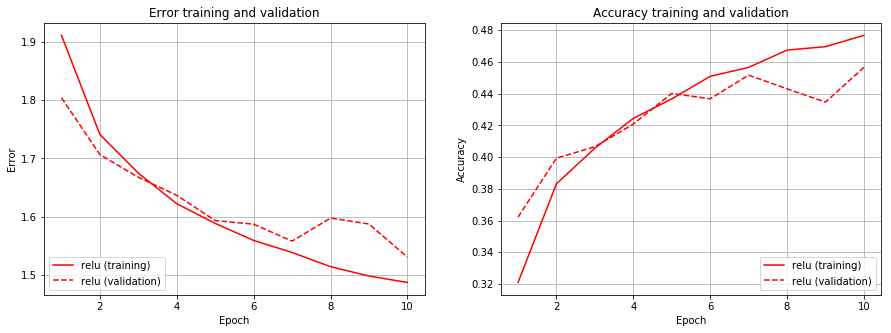

In [12]:
ax = plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(err_train_relu.keys(), err_train_relu.values(), 'r-', label='relu (training)')
plt.plot(err_valid_relu.keys(), err_valid_relu.values(), 'r--', label='relu (validation)')
plt.title('Error training and validation')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc='lower left', fontsize='medium')

plt.subplot(122)
plt.plot(acc_train_relu.keys(), acc_train_relu.values(), 'r-', label='relu (training)')
plt.plot(acc_valid_relu.keys(), acc_valid_relu.values(), 'r--', label='relu (validation)')
plt.title('Accuracy training and validation')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize='medium')

#plt.savefig('activation_functions.pdf', bbox_inches='tight')
plt.show()

# DEBUGGING

In [13]:
from IPython.display import display, HTML
import datetime

def show_graph(graph_def, frame_size=(900, 600)):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:{height}px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(height=frame_size[1], data=repr(str(graph_def)), id='graph'+timestamp)
    iframe = """
        <iframe seamless style="width:{width}px;height:{height}px;border:0" srcdoc="{src}"></iframe>
    """.format(width=frame_size[0], height=frame_size[1] + 20, src=code.replace('"', '&quot;'))
    display(HTML(iframe))

In [14]:
show_graph(tf.get_default_graph())